In [1]:
import tensorflow as tf

In [2]:
import numpy as np
from pandas import read_csv

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from numpy.random import seed
from tensorflow.random import set_seed

from sklearn.metrics import mean_squared_error

df = read_csv('starbucks.csv') 
var = df.columns.values[1]

porc_treinamento = 85

Série:  Close
Tamanho da série:  1006


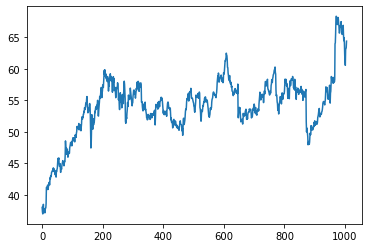

In [3]:
series = np.array(df[var])
plt.plot(series)
N = series.shape[0]

print("Série: ", var)
print("Tamanho da série: ", N)

Exemplos de Treinamento:  855
Exemplos de Teste:  150


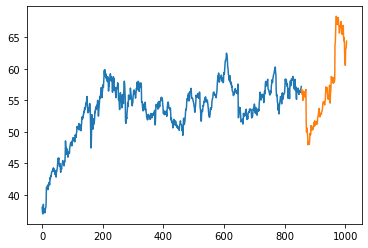

In [4]:
# calcula tamanhos dos dados de treinamento (n1) e teste (n2)
n1 = int(series.shape[0]*(porc_treinamento/100.0))
n2 = int(series.shape[0]*(1-(porc_treinamento/100.0)))

# divide dados de treinamento e teste
train, test = series[0:-n2], series[-n2:]

print("Exemplos de Treinamento: ", n1)
print("Exemplos de Teste: ", n2)
plt.plot(np.arange(0, n1+1), train)
plt.plot(np.arange(n1,n1+n2), test)

In [5]:
# modifica uma serie temporal tornando-a
# um problema de aprendizado supervisionado
def timeseries_to_supervised(series, look_back=1):
    x = series[:-look_back]
    y = np.array(series[look_back:], copy=True)
    return x,y

def normalize(train, test):
    d_max = np.max(train)
    d_min = np.min(train)		
    return ((train - d_min) / (d_max-d_min)), ((test - d_min) / (d_max-d_min))

In [6]:
#normalização
look_back = 1

n_train, n_test = normalize(train, test)

x_train, y_train = timeseries_to_supervised(n_train, look_back)
x_test, y_test = timeseries_to_supervised(n_test, look_back)

#alterando shape para [samples, time_steps, features]
rnn_train = np.reshape(x_train, (x_train.shape[0],1,1))
rnn_test = np.reshape(x_test, (x_test.shape[0],1,1))

In [7]:
#rede neural recorrente LSTM
#Camada recorrente (LSTM/GRU) com 16 unidades
#Camada recorrente (LSTM/GRU) com 8 unidades
#Dropout de 0.2
#Camada densa de predição
#ativação RELU

#sementes
seed(2)
set_seed(2)

#modelo LSTM
LSTM = keras.models.Sequential()
LSTM.add(keras.layers.LSTM(16, return_sequences=True, activation = 'relu', input_shape=(1,1)))
LSTM.add(keras.layers.LSTM(8, return_sequences=True, activation='relu'))
LSTM.add(keras.layers.Dropout(0.2))
#LSTM.add(keras.layers.Dense(1, activation='relu'))
LSTM.add(keras.layers.Dense(1))
LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 16)             1152      
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 8)              800       
_________________________________________________________________
dropout (Dropout)            (None, 1, 8)              0         
_________________________________________________________________
dense (Dense)                (None, 1, 1)              9         
Total params: 1,961
Trainable params: 1,961
Non-trainable params: 0
_________________________________________________________________


In [8]:
#rede neural recorrente GRU

#sementes
seed(2)
set_seed(2)

#modelo GRU
GRU = keras.models.Sequential()
GRU.add(keras.layers.GRU(16, return_sequences=True, activation='relu', input_shape=(1,1)))
GRU.add(keras.layers.GRU(8, return_sequences=True, activation='relu'))
GRU.add(keras.layers.Dropout(0.2))
#GRU.add(keras.layers.Dense(1, activation='relu'))
GRU.add(keras.layers.Dense(1))
GRU.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 1, 16)             912       
_________________________________________________________________
gru_1 (GRU)                  (None, 1, 8)              624       
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 8)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1, 1)              9         
Total params: 1,545
Trainable params: 1,545
Non-trainable params: 0
_________________________________________________________________


In [9]:
#treinando e compilando LSTM

#sementes
seed(2)
set_seed(2)


#epochs e batchsize
epochs = 15
batch_size = 1

LSTM.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
             loss='mse',
             metrics=['mse'])

hist_LSTM = LSTM.fit(rnn_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
pred_LSTM = LSTM.predict(rnn_test).reshape(-1)
mse_LSTM = mean_squared_error(y_test, pred_LSTM)

In [10]:
#treinando e compilando GRU

#sementes
seed(2)
set_seed(2)


#epochs e batchsize
epochs = 15
batch_size = 1

GRU.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
             loss='mse',
             metrics=['mse'])

hist_GRU = GRU.fit(rnn_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
pred_GRU = GRU.predict(rnn_test).reshape(-1)
mse_GRU = mean_squared_error(y_test, pred_GRU)

MSE de LSTM: 0.0048
MSE de GRU: 0.0119


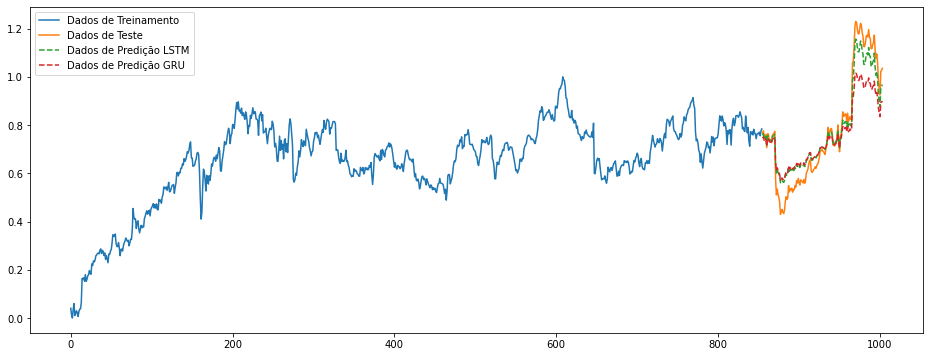

In [11]:
print('MSE de LSTM:','%.4f' % mse_LSTM)
print('MSE de GRU:','%.4f' % mse_GRU)

plt.figure(figsize=(16,6))
plt.plot(x_train,label='Dados de Treinamento')
plt.plot(np.arange(n1,n1+n2-1), x_test,label = 'Dados de Teste')
plt.plot(np.arange(n1,n1+n2-1), pred_LSTM,'--', label = 'Dados de Predição LSTM')
plt.plot(np.arange(n1,n1+n2-1), pred_GRU,'--', label = 'Dados de Predição GRU')
fig = plt.legend()